# VAEGAN: Hybrid VAE-GAN Model

This notebook implements a hybrid VAEGAN model that combines:
- VAE as generator with 4-layer encoder/decoder
- WGAN critic for adversarial training
- Modified VAE loss with critic feedback


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import logging
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(name)s | %(levelname)s | %(message)s'
)
logger = logging.getLogger('VAEGAN')
logger.info(f"Device: {device}")


VAEGAN | INFO | Device: cuda


In [3]:
class DataLoaderModule:
    """Simple dataloader for MNIST and CIFAR10"""
    
    def __init__(self, batch_size=64):
        self.batch_size = batch_size
        self.logger = logging.getLogger('VAEGAN.DataLoader')
        
    def load_mnist(self):
        self.logger.info("Loading MNIST dataset")
        transform = transforms.Compose([
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # [-1, 1] range
        ])
        
        dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        self.logger.info(f"MNIST loaded: {len(dataloader)} batches")
        return dataloader, 1, [64, 64]
    
    def load_cifar10(self):
        self.logger.info("Loading CIFAR10 dataset")
        transform = transforms.Compose([
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # [-1, 1] range
        ])
        
        dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        self.logger.info(f"CIFAR10 loaded: {len(dataloader)} batches")
        return dataloader, 3, [64, 64]


In [4]:
class VAEGenerator(nn.Module):
    """Dynamic VAE with 4-layer encoder and decoder based on latent_dim"""
    
    def __init__(self, input_channels=1, latent_dim=128, img_size=64):
        super().__init__()
        self.latent_dim = latent_dim
        self.img_size = img_size
        self.logger = logging.getLogger('VAEGAN.VAEGenerator')
        
        # Dynamic channel sizes based on latent_dim
        base_dim = latent_dim // 2  # latent_dim/2
        dim2 = latent_dim           # latent_dim
        dim3 = latent_dim * 2       # latent_dim*2  
        dim4 = latent_dim * 4       # latent_dim*4
        
        # 4-layer encoder - progressively increase channels
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, base_dim, 4, 2, 1),  # 64x64 -> 32x32
            nn.BatchNorm2d(base_dim),
            nn.ReLU(),
            
            nn.Conv2d(base_dim, dim2, 4, 2, 1),  # 32x32 -> 16x16
            nn.BatchNorm2d(dim2),
            nn.ReLU(),
            
            nn.Conv2d(dim2, dim3, 4, 2, 1),  # 16x16 -> 8x8
            nn.BatchNorm2d(dim3),
            nn.ReLU(),
            
            nn.Conv2d(dim3, dim4, 4, 2, 1),  # 8x8 -> 4x4
            nn.BatchNorm2d(dim4),
            nn.ReLU(),
        )
        
        # Latent projection
        self.fc_mu = nn.Linear(dim4 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(dim4 * 4 * 4, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, dim4 * 4 * 4)
        
        # 4-layer decoder - progressively decrease channels
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(dim4, dim3, 4, 2, 1),  # 4x4 -> 8x8
            nn.BatchNorm2d(dim3),
            nn.ReLU(),
            
            nn.ConvTranspose2d(dim3, dim2, 4, 2, 1),  # 8x8 -> 16x16
            nn.BatchNorm2d(dim2),
            nn.ReLU(),
            
            nn.ConvTranspose2d(dim2, base_dim, 4, 2, 1),  # 16x16 -> 32x32
            nn.BatchNorm2d(base_dim),
            nn.ReLU(),
            
            nn.ConvTranspose2d(base_dim, input_channels, 4, 2, 1),  # 32x32 -> 64x64
            nn.Tanh()
        )
        
        self.logger.info(f"Dynamic VAE Generator: channels={input_channels}, latent_dim={latent_dim}, dims=[{base_dim}, {dim2}, {dim3}, {dim4}]")
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(h.size(0), self.latent_dim * 4, 4, 4)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [5]:
class Critic(nn.Module):
    """Dynamic WGAN-GP Critic with gradient penalty"""
    
    def __init__(self, input_channels=1, latent_dim=128):
        super().__init__()
        self.logger = logging.getLogger('VAEGAN.Critic')
        
        # Dynamic channel sizes based on latent_dim
        base_dim = latent_dim // 2  # latent_dim/2
        dim2 = latent_dim           # latent_dim
        dim3 = latent_dim * 2       # latent_dim*2
        dim4 = latent_dim * 4       # latent_dim*4
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, base_dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(base_dim, dim2, 4, 2, 1),
            nn.BatchNorm2d(dim2),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(dim2, dim3, 4, 2, 1),
            nn.BatchNorm2d(dim3),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(dim3, dim4, 4, 2, 1),
            nn.BatchNorm2d(dim4),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Linear(dim4 * 4 * 4, 1)
        self.logger.info(f"Dynamic Critic: channels={input_channels}, latent_dim={latent_dim}, dims=[{base_dim}, {dim2}, {dim3}, {dim4}]")
    
    def forward(self, x):
        h = self.conv_layers(x)
        h = h.view(h.size(0), -1)
        return self.fc(h).squeeze()
    
    def gradient_penalty(self, real_images, fake_images, device):
        """Calculate gradient penalty for WGAN-GP"""
        batch_size = real_images.size(0)
        
        # Random interpolation weight
        alpha = torch.rand(batch_size, 1, 1, 1, device=device)
        
        # Interpolated images
        interpolated = alpha * real_images + (1 - alpha) * fake_images
        interpolated.requires_grad_(True)
        
        # Critic scores for interpolated images
        scores = self.forward(interpolated)
        
        # Calculate gradients
        gradients = torch.autograd.grad(
            outputs=scores,
            inputs=interpolated,
            grad_outputs=torch.ones_like(scores),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        
        # Gradient penalty
        gradients = gradients.view(batch_size, -1)
        gradient_norm = gradients.norm(2, dim=1)
        penalty = torch.mean((gradient_norm - 1) ** 2)
        
        return penalty


In [6]:
class VAEGAN(nn.Module):
    """Dynamic Hybrid VAEGAN model with VAE generator and WGAN-GP critic"""
    
    def __init__(self, input_channels=1, latent_dim=128, img_size=64, lambda_gp=10):
        super().__init__()
        self.logger = logging.getLogger('VAEGAN.Model')
        self.lambda_gp = lambda_gp
        
        # Dynamic models based on latent_dim
        self.generator = VAEGenerator(input_channels, latent_dim, img_size).to(device)
        self.critic = Critic(input_channels, latent_dim).to(device)
        
        self.logger.info(f"Dynamic VAEGAN initialized: latent_dim={latent_dim}, lambda_gp={lambda_gp}")
    
    def vae_loss(self, x, recon, mu, logvar, critic_score):
        """Modified VAE loss with critic feedback"""
        # Standard VAE losses
        recon_loss = F.mse_loss(recon, x, reduction='mean')
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        
        # Adversarial loss - generator wants high critic scores
        adv_loss = -torch.mean(critic_score)
        
        return recon_loss, kl_loss, adv_loss
    
    def critic_loss(self, real_score, fake_score, gp):
        """WGAN-GP critic loss with gradient penalty"""
        return torch.mean(fake_score) - torch.mean(real_score) + self.lambda_gp * gp
    
    def train_step(self, real_images, g_optimizer, c_optimizer, 
                   recon_weight=1.0, kl_weight=0.1, adv_weight=0.1, critic_iters=5):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        
        # Train Critic multiple times with gradient penalty
        for _ in range(critic_iters):
            c_optimizer.zero_grad()
            
            # Real images
            real_score = self.critic(real_images)
            
            # Fake images from VAE
            with torch.no_grad():
                fake_images, _, _ = self.generator(real_images)
            fake_score = self.critic(fake_images)
            
            # Gradient penalty
            gp = self.critic.gradient_penalty(real_images, fake_images, device)
            
            c_loss = self.critic_loss(real_score, fake_score, gp)
            c_loss.backward()
            c_optimizer.step()
        
        # Train Generator (VAE)
        g_optimizer.zero_grad()
        
        # VAE forward pass
        recon, mu, logvar = self.generator(real_images)
        
        # Get critic score for reconstructed images
        critic_score = self.critic(recon)
        
        # Calculate losses
        recon_loss, kl_loss, adv_loss = self.vae_loss(real_images, recon, mu, logvar, critic_score)
        
        # Combined generator loss
        g_loss = recon_weight * recon_loss + kl_weight * kl_loss + adv_weight * adv_loss
        g_loss.backward()
        g_optimizer.step()
        
        return {
            'g_loss': g_loss.item(),
            'c_loss': c_loss.item(),
            'recon_loss': recon_loss.item(),
            'kl_loss': kl_loss.item(),
            'adv_loss': adv_loss.item(),
            'gp': gp.item()
        }


In [7]:
class Trainer:
    """Training loop with visualization"""
    
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.history = defaultdict(list)
        self.logger = logging.getLogger('VAEGAN.Trainer')
        
    def train(self, dataloader, epochs=10, lr_g=1e-3, lr_c=5e-5, critic_iters=5):
        self.logger.info(f"Starting training for {epochs} epochs")
        
        # Use Adam for both optimizers with WGAN-GP
        g_optimizer = optim.Adam(self.model.generator.parameters(), lr=lr_g, betas=(0.0, 0.9))
        c_optimizer = optim.Adam(self.model.critic.parameters(), lr=lr_c, betas=(0.0, 0.9))
        
        for epoch in range(epochs):
            epoch_metrics = defaultdict(list)
            
            for batch_idx, (real_images, _) in enumerate(dataloader):
                metrics = self.model.train_step(real_images, g_optimizer, c_optimizer, critic_iters=1)
                
                for key, value in metrics.items():
                    epoch_metrics[key].append(value)
                    self.history[key].append(value)
                
                if batch_idx % 100 == 0:
                    self.logger.info(
                        f"Epoch {epoch} Batch {batch_idx}: "
                        f"G_loss={metrics['g_loss']:.4f} "
                        f"C_loss={metrics['c_loss']:.4f} "
                        f"Recon={metrics['recon_loss']:.4f} "
                        f"GP={metrics['gp']:.4f}"
                    )
            
            # Epoch summary
            avg_metrics = {k: np.mean(v) for k, v in epoch_metrics.items()}
            self.logger.info(
                f"Epoch {epoch} complete: "
                f"G_loss={avg_metrics['g_loss']:.4f} "
                f"C_loss={avg_metrics['c_loss']:.4f} "
                f"Recon={avg_metrics['recon_loss']:.4f} "
                f"KL={avg_metrics['kl_loss']:.4f} "
                f"Adv={avg_metrics['adv_loss']:.4f} "
                f"GP={avg_metrics['gp']:.4f}"
            )
            
            # Visualize reconstruction after each epoch
            self.plot_reconstruction(dataloader, epoch)
    
    def plot_reconstruction(self, dataloader, epoch):
        """Plot original vs reconstructed images"""
        self.model.eval()
        
        with torch.no_grad():
            # Get sample batch
            for real_images, _ in dataloader:
                break
            
            real_images = real_images[:8].to(self.device)
            recon_images, _, _ = self.model.generator(real_images)
            
            # Plot comparison
            fig, axes = plt.subplots(2, 8, figsize=(16, 4))
            
            for i in range(8):
                # Original
                img = real_images[i].cpu()
                if img.shape[0] == 1:
                    axes[0, i].imshow(img.squeeze(), cmap='gray', vmin=-1, vmax=1)
                else:
                    img = (img + 1) / 2  # Denormalize
                    axes[0, i].imshow(img.permute(1, 2, 0))
                axes[0, i].axis('off')
                
                # Reconstructed
                img = recon_images[i].cpu()
                if img.shape[0] == 1:
                    axes[1, i].imshow(img.squeeze(), cmap='gray', vmin=-1, vmax=1)
                else:
                    img = (img + 1) / 2  # Denormalize
                    axes[1, i].imshow(img.permute(1, 2, 0))
                axes[1, i].axis('off')
            
            axes[0, 0].set_ylabel('Original', fontsize=12)
            axes[1, 0].set_ylabel('Reconstructed', fontsize=12)
            plt.suptitle(f'Reconstruction Quality - Epoch {epoch}', fontsize=14)
            plt.tight_layout()
            plt.show()
        
        self.model.train()
    
    def plot_history(self):
        """Plot training loss history"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        
        metrics = ['g_loss', 'c_loss', 'recon_loss', 'kl_loss', 'adv_loss', 'gp']
        
        for i, metric in enumerate(metrics):
            if metric in self.history:
                row, col = i // 3, i % 3
                axes[row, col].plot(self.history[metric])
                axes[row, col].set_title(metric.replace('_', ' ').title())
                axes[row, col].grid(True)
        
        # All subplots should be filled now with 6 metrics
        
        plt.suptitle('Training History', fontsize=16)
        plt.tight_layout()
        plt.show()


VAEGAN | INFO | Starting VAEGAN training
VAEGAN | INFO | ==================================================
VAEGAN.DataLoader | INFO | Loading MNIST dataset
VAEGAN.DataLoader | INFO | MNIST loaded: 600 batches
VAEGAN.VAEGenerator | INFO | Dynamic VAE Generator: channels=1, latent_dim=64, dims=[32, 64, 128, 256]
VAEGAN.Critic | INFO | Dynamic Critic: channels=1, latent_dim=64, dims=[32, 64, 128, 256]
VAEGAN.Model | INFO | Dynamic VAEGAN initialized: latent_dim=64, lambda_gp=10
VAEGAN | INFO | Training on MNIST
VAEGAN.Trainer | INFO | Starting training for 10 epochs
/home/sbeeredd/miniconda3/envs/env/lib/python3.11/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1729647429097/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward

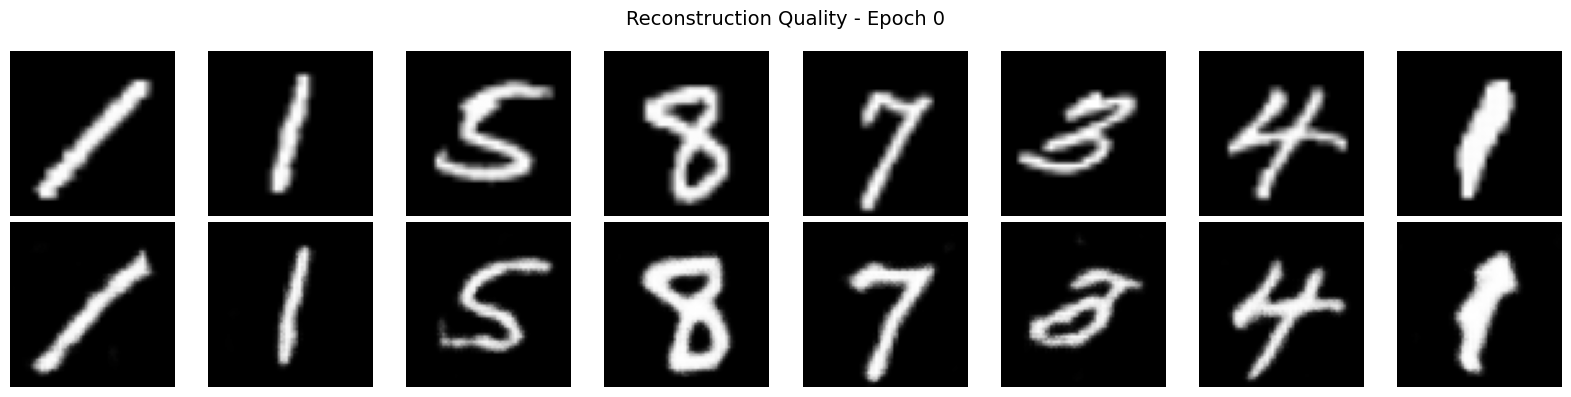

VAEGAN.Trainer | INFO | Epoch 1 Batch 0: G_loss=-1.3051 C_loss=-0.3450 Recon=0.0596 GP=0.0062
VAEGAN.Trainer | INFO | Epoch 1 Batch 100: G_loss=-1.1114 C_loss=-0.0701 Recon=0.0501 GP=0.0316
VAEGAN.Trainer | INFO | Epoch 1 Batch 200: G_loss=-1.2401 C_loss=-0.7321 Recon=0.0557 GP=0.0109
VAEGAN.Trainer | INFO | Epoch 1 Batch 300: G_loss=-1.1814 C_loss=-0.3429 Recon=0.0558 GP=0.0272
VAEGAN.Trainer | INFO | Epoch 1 Batch 400: G_loss=-1.0350 C_loss=-0.4284 Recon=0.0488 GP=0.0504
VAEGAN.Trainer | INFO | Epoch 1 Batch 500: G_loss=-1.0124 C_loss=-0.5434 Recon=0.0508 GP=0.0168
VAEGAN.Trainer | INFO | Epoch 1 complete: G_loss=-1.2100 C_loss=-0.3854 Recon=0.0564 KL=0.5594 Adv=-13.2237 GP=0.0191


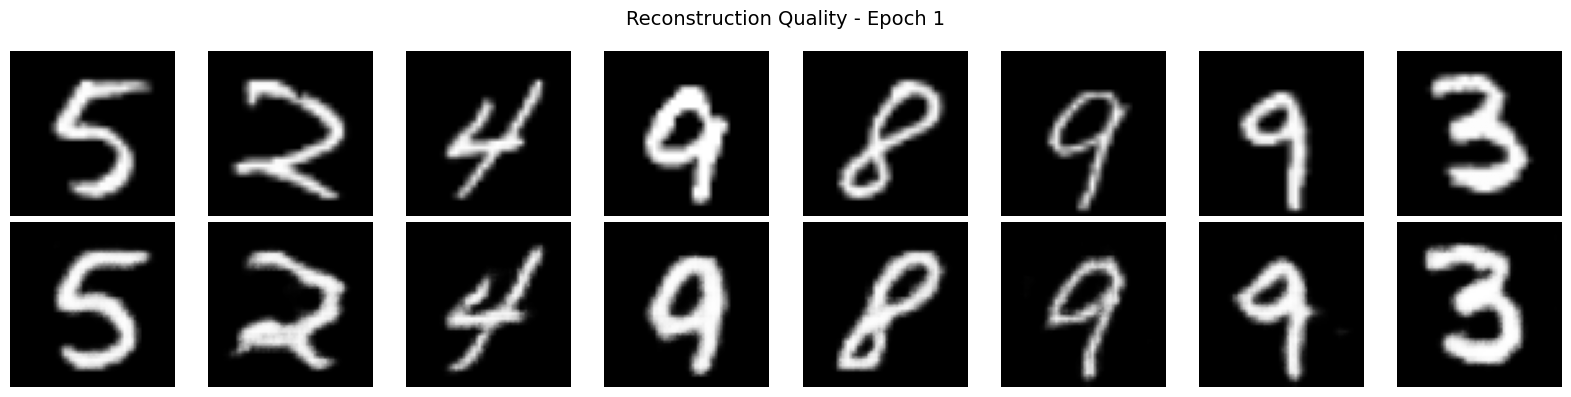

VAEGAN.Trainer | INFO | Epoch 2 Batch 0: G_loss=-0.9862 C_loss=-0.3314 Recon=0.0455 GP=0.0037
VAEGAN.Trainer | INFO | Epoch 2 Batch 100: G_loss=-0.8363 C_loss=-0.2280 Recon=0.0493 GP=0.0325
VAEGAN.Trainer | INFO | Epoch 2 Batch 200: G_loss=-0.8047 C_loss=-0.5939 Recon=0.0452 GP=0.0057
VAEGAN.Trainer | INFO | Epoch 2 Batch 300: G_loss=-0.6468 C_loss=-0.4802 Recon=0.0465 GP=0.0189
VAEGAN.Trainer | INFO | Epoch 2 Batch 400: G_loss=-0.6454 C_loss=-0.6432 Recon=0.0448 GP=0.0035
VAEGAN.Trainer | INFO | Epoch 2 Batch 500: G_loss=-0.6003 C_loss=-0.4656 Recon=0.0428 GP=0.0063
VAEGAN.Trainer | INFO | Epoch 2 complete: G_loss=-0.7277 C_loss=-0.4559 Recon=0.0457 KL=0.5424 Adv=-8.2770 GP=0.0131


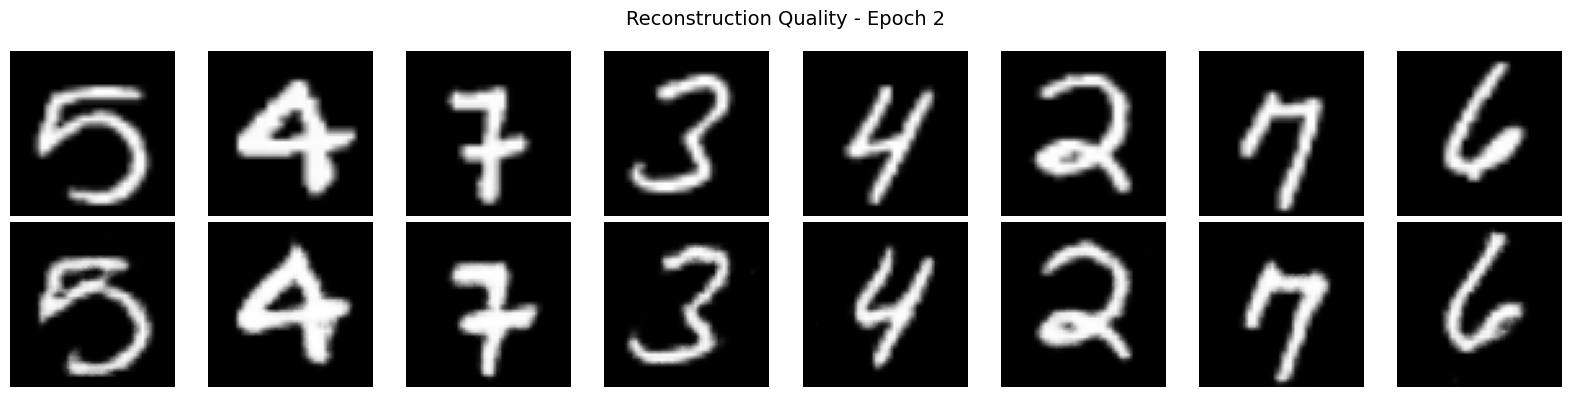

VAEGAN.Trainer | INFO | Epoch 3 Batch 0: G_loss=-0.4827 C_loss=-0.4833 Recon=0.0430 GP=0.0053
VAEGAN.Trainer | INFO | Epoch 3 Batch 100: G_loss=-0.3347 C_loss=-0.5330 Recon=0.0447 GP=0.0148
VAEGAN.Trainer | INFO | Epoch 3 Batch 200: G_loss=-0.3387 C_loss=-0.4310 Recon=0.0429 GP=0.0080
VAEGAN.Trainer | INFO | Epoch 3 Batch 300: G_loss=-0.1181 C_loss=-0.5621 Recon=0.0368 GP=0.0098
VAEGAN.Trainer | INFO | Epoch 3 Batch 400: G_loss=-0.1642 C_loss=-0.5662 Recon=0.0391 GP=0.0045
VAEGAN.Trainer | INFO | Epoch 3 Batch 500: G_loss=-0.0862 C_loss=-0.5464 Recon=0.0363 GP=0.0016
VAEGAN.Trainer | INFO | Epoch 3 complete: G_loss=-0.2208 C_loss=-0.4901 Recon=0.0414 KL=0.5319 Adv=-3.1540 GP=0.0104


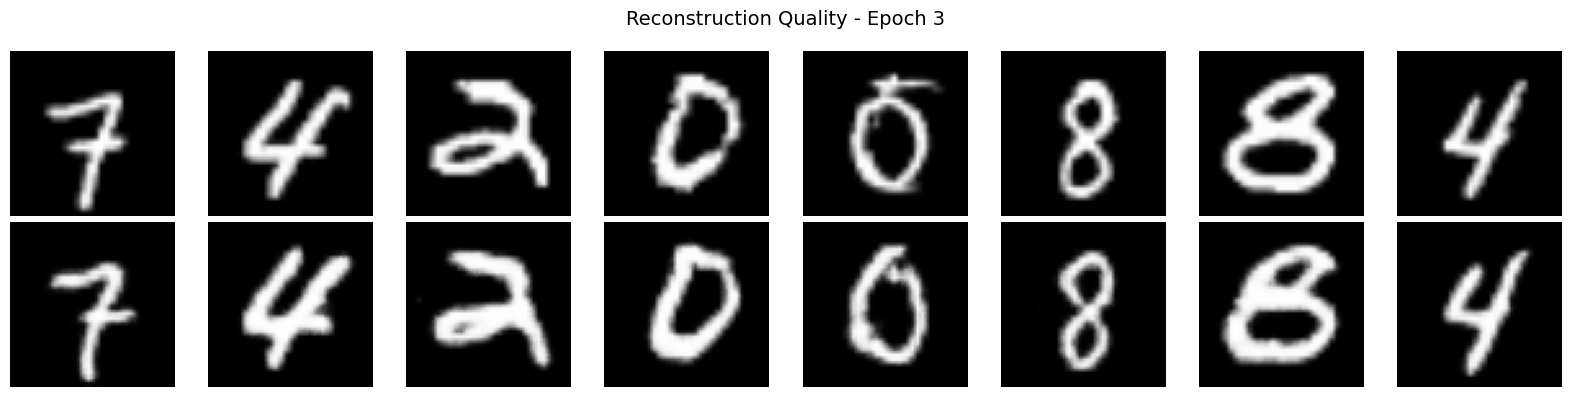

VAEGAN.Trainer | INFO | Epoch 4 Batch 0: G_loss=0.0387 C_loss=-0.3429 Recon=0.0452 GP=0.0076
VAEGAN.Trainer | INFO | Epoch 4 Batch 100: G_loss=0.1385 C_loss=-0.5282 Recon=0.0374 GP=0.0124
VAEGAN.Trainer | INFO | Epoch 4 Batch 200: G_loss=0.1548 C_loss=-0.5339 Recon=0.0389 GP=0.0027
VAEGAN.Trainer | INFO | Epoch 4 Batch 300: G_loss=0.1931 C_loss=-0.5577 Recon=0.0399 GP=0.0026
VAEGAN.Trainer | INFO | Epoch 4 Batch 400: G_loss=0.2941 C_loss=-0.6374 Recon=0.0400 GP=0.0063
VAEGAN.Trainer | INFO | Epoch 4 Batch 500: G_loss=0.2886 C_loss=-0.5930 Recon=0.0403 GP=0.0024
VAEGAN.Trainer | INFO | Epoch 4 complete: G_loss=0.2141 C_loss=-0.5113 Recon=0.0392 KL=0.5287 Adv=1.2198 GP=0.0089


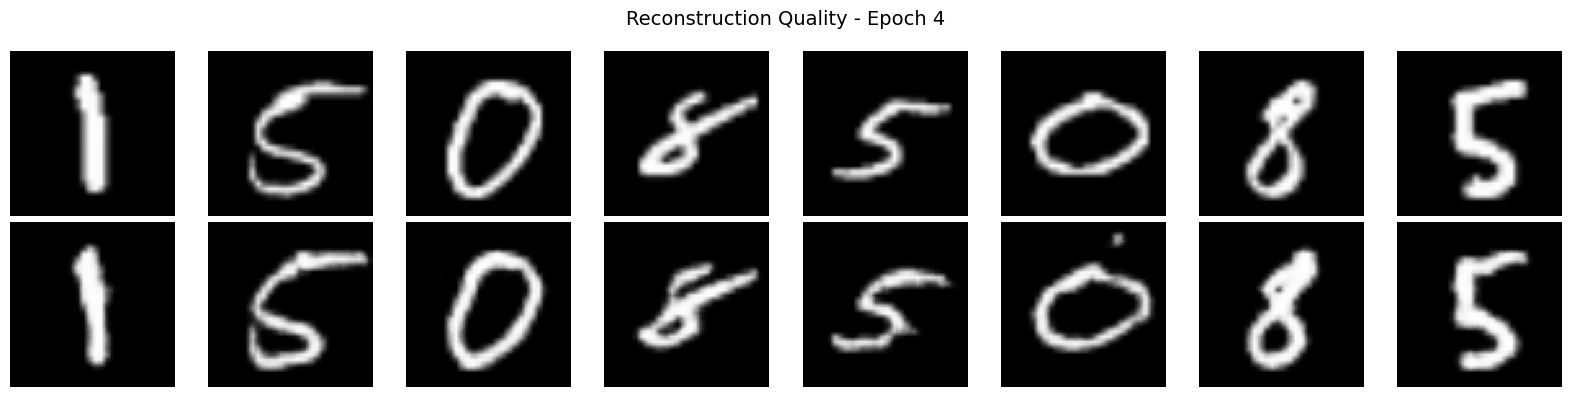

VAEGAN.Trainer | INFO | Epoch 5 Batch 0: G_loss=0.3358 C_loss=-0.6404 Recon=0.0370 GP=0.0073
VAEGAN.Trainer | INFO | Epoch 5 Batch 100: G_loss=0.3826 C_loss=-0.6029 Recon=0.0348 GP=0.0021
VAEGAN.Trainer | INFO | Epoch 5 Batch 200: G_loss=0.5048 C_loss=-0.0787 Recon=0.0339 GP=0.0315
VAEGAN.Trainer | INFO | Epoch 5 Batch 300: G_loss=0.5821 C_loss=-0.5294 Recon=0.0359 GP=0.0017
VAEGAN.Trainer | INFO | Epoch 5 Batch 400: G_loss=0.6832 C_loss=-0.5233 Recon=0.0352 GP=0.0016
VAEGAN.Trainer | INFO | Epoch 5 Batch 500: G_loss=0.6414 C_loss=-0.5108 Recon=0.0378 GP=0.0023
VAEGAN.Trainer | INFO | Epoch 5 complete: G_loss=0.5702 C_loss=-0.5229 Recon=0.0378 KL=0.5276 Adv=4.7968 GP=0.0083


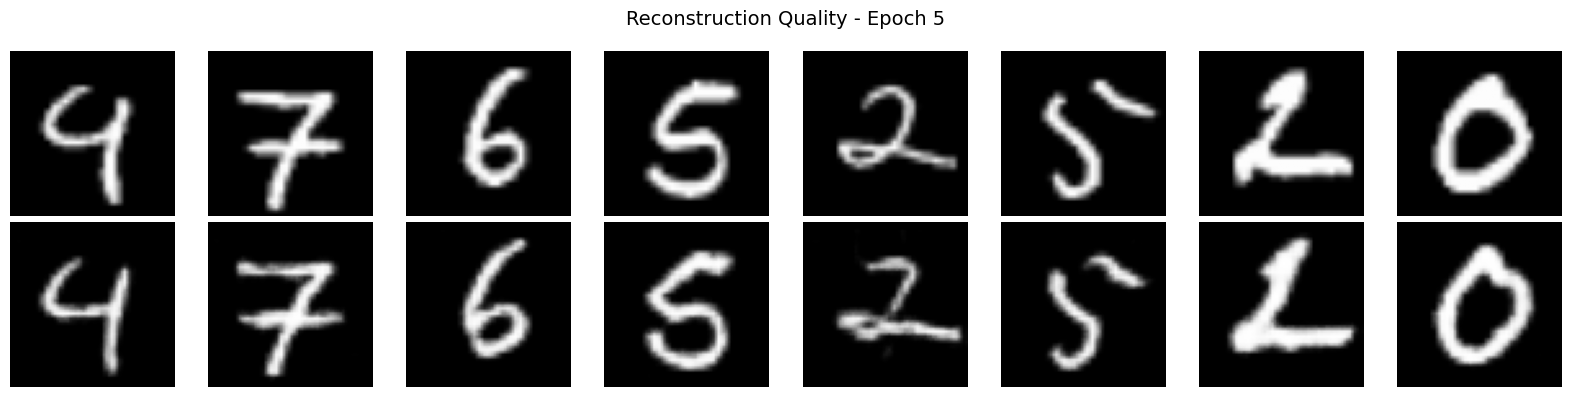

VAEGAN.Trainer | INFO | Epoch 6 Batch 0: G_loss=0.6497 C_loss=-0.4047 Recon=0.0362 GP=0.0278
VAEGAN.Trainer | INFO | Epoch 6 Batch 100: G_loss=0.8063 C_loss=-0.6027 Recon=0.0385 GP=0.0018
VAEGAN.Trainer | INFO | Epoch 6 Batch 200: G_loss=0.8195 C_loss=-0.6183 Recon=0.0379 GP=0.0108
VAEGAN.Trainer | INFO | Epoch 6 Batch 300: G_loss=0.8768 C_loss=-0.5596 Recon=0.0389 GP=0.0011
VAEGAN.Trainer | INFO | Epoch 6 Batch 400: G_loss=0.9119 C_loss=-0.5966 Recon=0.0388 GP=0.0033
VAEGAN.Trainer | INFO | Epoch 6 Batch 500: G_loss=1.0166 C_loss=-0.6311 Recon=0.0362 GP=0.0043
VAEGAN.Trainer | INFO | Epoch 6 complete: G_loss=0.8933 C_loss=-0.5303 Recon=0.0368 KL=0.5239 Adv=8.0408 GP=0.0078


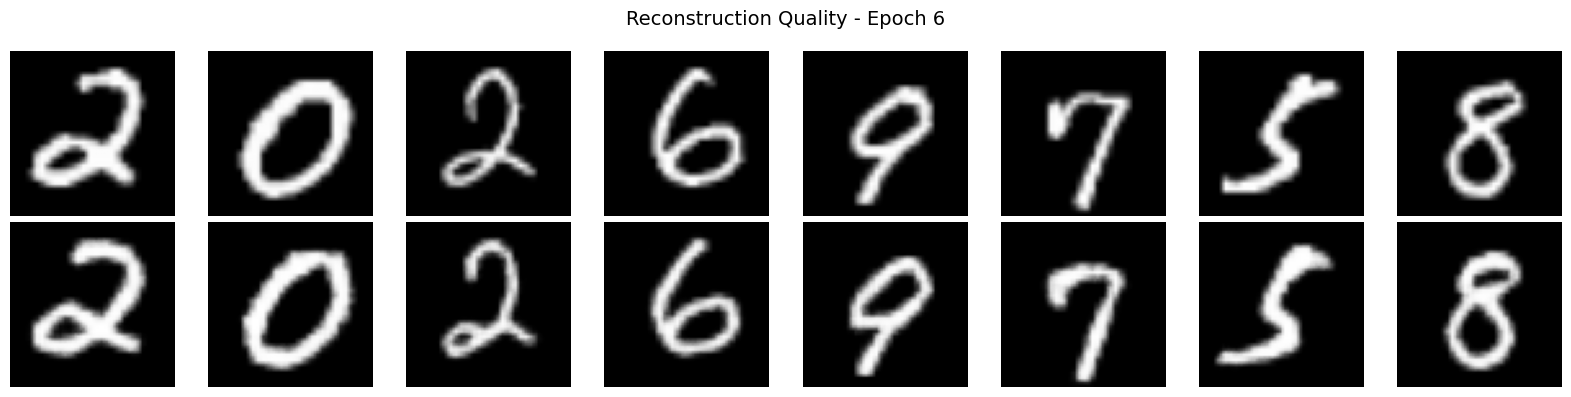

VAEGAN.Trainer | INFO | Epoch 7 Batch 0: G_loss=1.0040 C_loss=-0.3593 Recon=0.0378 GP=0.0117
VAEGAN.Trainer | INFO | Epoch 7 Batch 100: G_loss=1.0735 C_loss=-0.5745 Recon=0.0375 GP=0.0106
VAEGAN.Trainer | INFO | Epoch 7 Batch 200: G_loss=1.1782 C_loss=-0.2099 Recon=0.0379 GP=0.0171
VAEGAN.Trainer | INFO | Epoch 7 Batch 300: G_loss=1.2021 C_loss=-0.4947 Recon=0.0373 GP=0.0095
VAEGAN.Trainer | INFO | Epoch 7 Batch 400: G_loss=1.0920 C_loss=-0.4706 Recon=0.0335 GP=0.0131
VAEGAN.Trainer | INFO | Epoch 7 Batch 500: G_loss=1.1774 C_loss=-0.6400 Recon=0.0334 GP=0.0032
VAEGAN.Trainer | INFO | Epoch 7 complete: G_loss=1.1215 C_loss=-0.5309 Recon=0.0362 KL=0.5229 Adv=10.3301 GP=0.0073


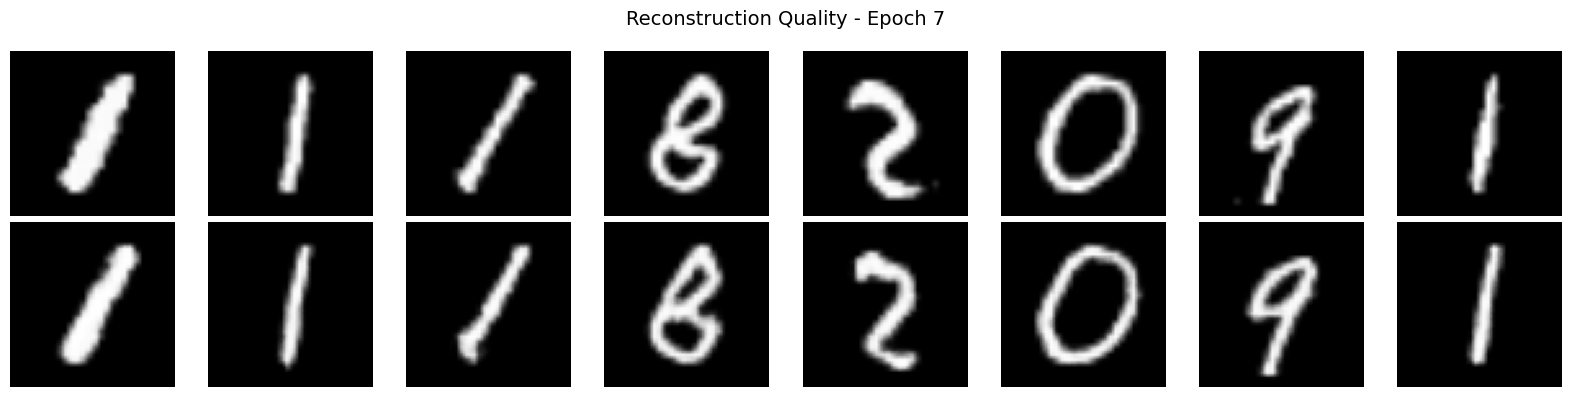

VAEGAN.Trainer | INFO | Epoch 8 Batch 0: G_loss=1.2889 C_loss=-0.5658 Recon=0.0323 GP=0.0077
VAEGAN.Trainer | INFO | Epoch 8 Batch 100: G_loss=1.1054 C_loss=-0.2571 Recon=0.0357 GP=0.0168
VAEGAN.Trainer | INFO | Epoch 8 Batch 200: G_loss=1.2892 C_loss=-0.4924 Recon=0.0351 GP=0.0034
VAEGAN.Trainer | INFO | Epoch 8 Batch 300: G_loss=1.3244 C_loss=-0.5917 Recon=0.0367 GP=0.0029
VAEGAN.Trainer | INFO | Epoch 8 Batch 400: G_loss=1.2887 C_loss=-0.3772 Recon=0.0389 GP=0.0158
VAEGAN.Trainer | INFO | Epoch 8 Batch 500: G_loss=1.3569 C_loss=-0.5898 Recon=0.0349 GP=0.0019
VAEGAN.Trainer | INFO | Epoch 8 complete: G_loss=1.3225 C_loss=-0.5277 Recon=0.0356 KL=0.5220 Adv=12.3467 GP=0.0069


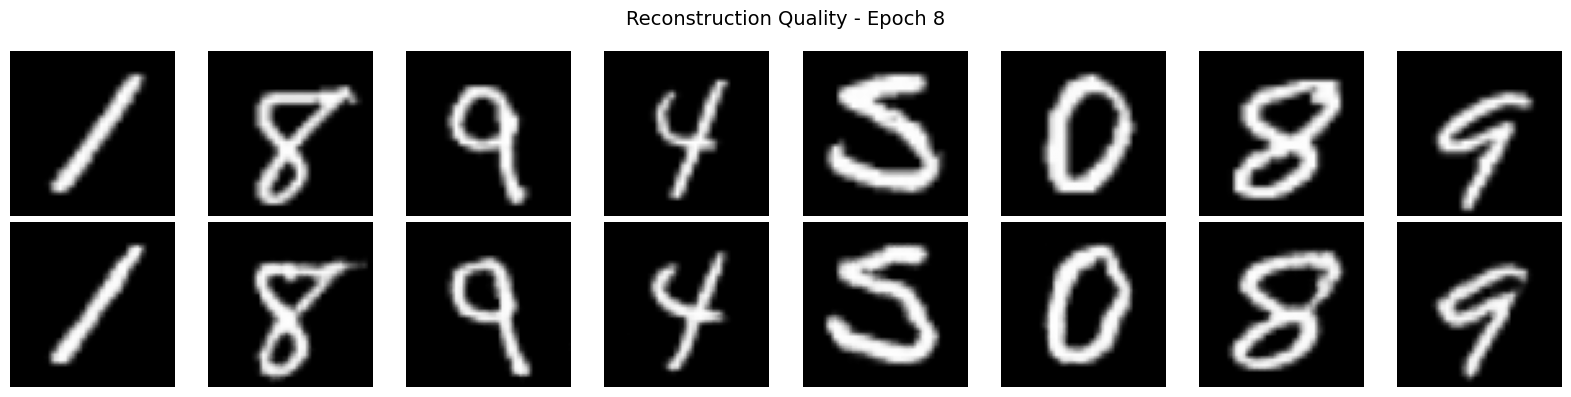

VAEGAN.Trainer | INFO | Epoch 9 Batch 0: G_loss=1.4761 C_loss=-0.5617 Recon=0.0383 GP=0.0086
VAEGAN.Trainer | INFO | Epoch 9 Batch 100: G_loss=1.4795 C_loss=-0.5002 Recon=0.0344 GP=0.0026
VAEGAN.Trainer | INFO | Epoch 9 Batch 200: G_loss=1.4323 C_loss=-0.3810 Recon=0.0362 GP=0.0208
VAEGAN.Trainer | INFO | Epoch 9 Batch 300: G_loss=1.5486 C_loss=-0.5338 Recon=0.0328 GP=0.0115
VAEGAN.Trainer | INFO | Epoch 9 Batch 400: G_loss=1.4612 C_loss=-0.3347 Recon=0.0336 GP=0.0127
VAEGAN.Trainer | INFO | Epoch 9 Batch 500: G_loss=1.5290 C_loss=-0.6816 Recon=0.0371 GP=0.0014
VAEGAN.Trainer | INFO | Epoch 9 complete: G_loss=1.5312 C_loss=-0.5246 Recon=0.0352 KL=0.5206 Adv=14.4397 GP=0.0067


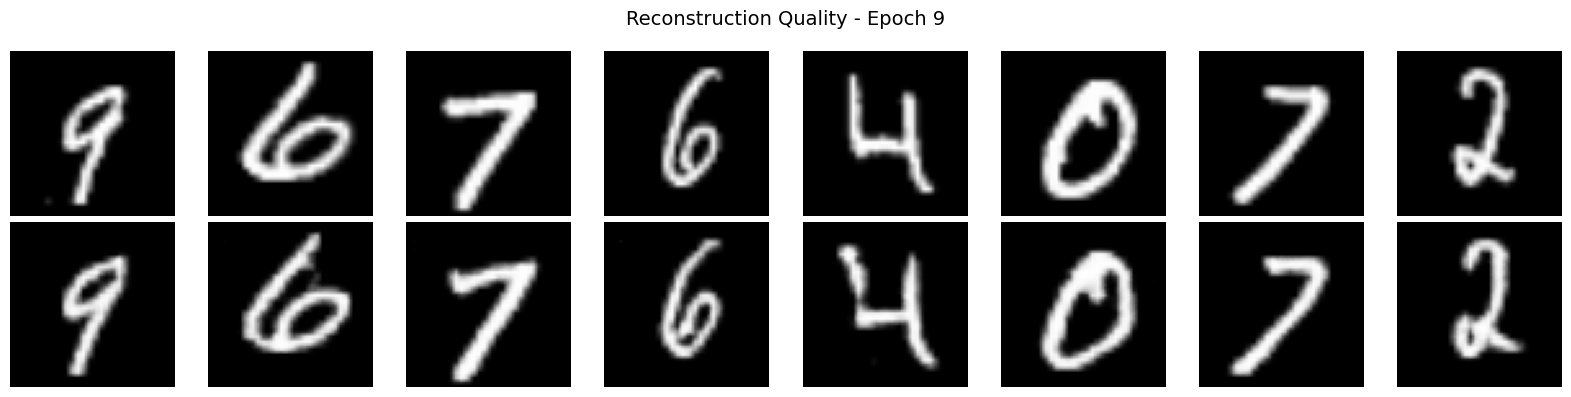

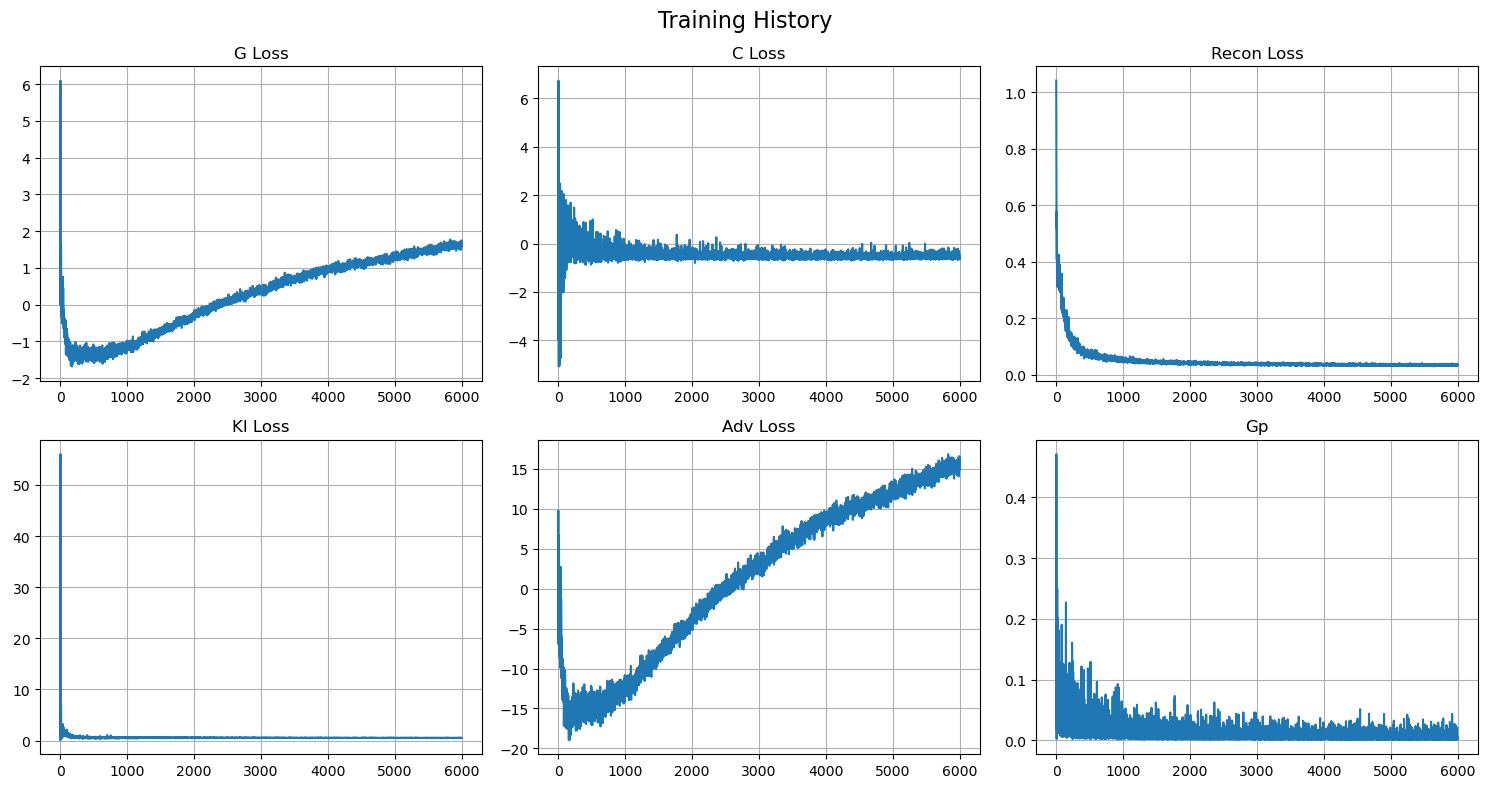

VAEGAN | INFO | Training completed
VAEGAN | INFO | Training on CIFAR10
VAEGAN.DataLoader | INFO | Loading CIFAR10 dataset


Files already downloaded and verified


VAEGAN.DataLoader | INFO | CIFAR10 loaded: 500 batches
VAEGAN.VAEGenerator | INFO | Dynamic VAE Generator: channels=3, latent_dim=128, dims=[64, 128, 256, 512]
VAEGAN.Critic | INFO | Dynamic Critic: channels=3, latent_dim=128, dims=[64, 128, 256, 512]
VAEGAN.Model | INFO | Dynamic VAEGAN initialized: latent_dim=128, lambda_gp=10
VAEGAN.Trainer | INFO | Starting training for 5 epochs
VAEGAN.Trainer | INFO | Epoch 0 Batch 0: G_loss=0.5745 C_loss=2.4996 Recon=0.5981 GP=0.2402
VAEGAN.Trainer | INFO | Epoch 0 Batch 100: G_loss=0.5477 C_loss=0.7039 Recon=0.5917 GP=0.0664
VAEGAN.Trainer | INFO | Epoch 0 Batch 200: G_loss=0.5325 C_loss=0.1146 Recon=0.5782 GP=0.0278
VAEGAN.Trainer | INFO | Epoch 0 Batch 300: G_loss=0.5639 C_loss=-0.4446 Recon=0.5881 GP=0.0056
VAEGAN.Trainer | INFO | Epoch 0 Batch 400: G_loss=0.5582 C_loss=-0.8114 Recon=0.5631 GP=0.0033
VAEGAN.Trainer | INFO | Epoch 0 complete: G_loss=0.5549 C_loss=0.0925 Recon=0.5813 KL=0.3886 Adv=-0.6525 GP=0.0412


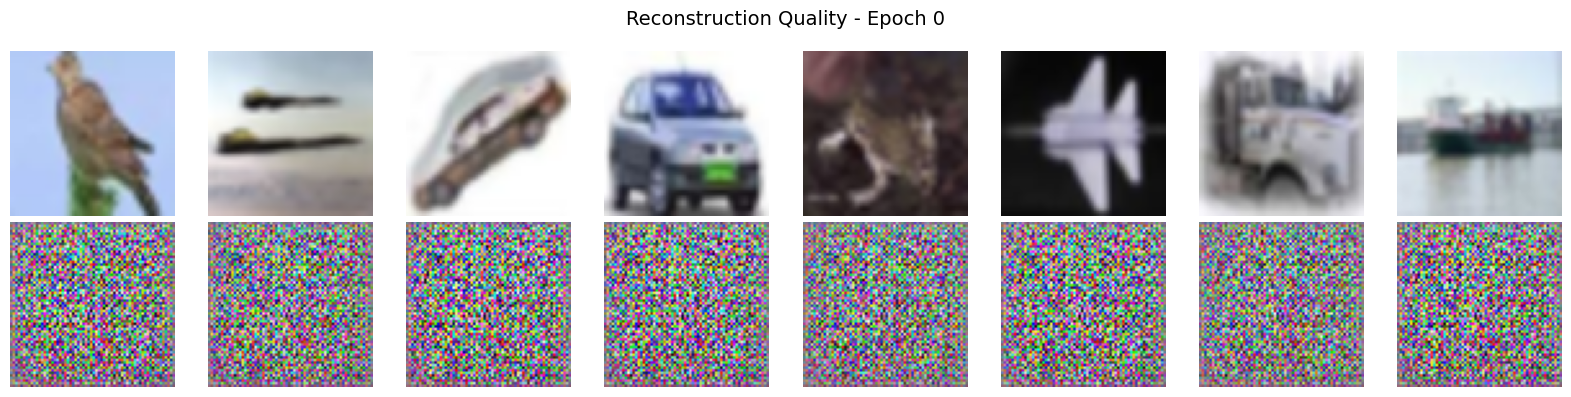

VAEGAN.Trainer | INFO | Epoch 1 Batch 0: G_loss=0.5780 C_loss=-0.9154 Recon=0.5677 GP=0.0061
VAEGAN.Trainer | INFO | Epoch 1 Batch 100: G_loss=0.5471 C_loss=-0.5109 Recon=0.5434 GP=0.0015
VAEGAN.Trainer | INFO | Epoch 1 Batch 200: G_loss=0.5691 C_loss=-0.2558 Recon=0.5705 GP=0.0045
VAEGAN.Trainer | INFO | Epoch 1 Batch 300: G_loss=0.5654 C_loss=-0.2206 Recon=0.5789 GP=0.0043
VAEGAN.Trainer | INFO | Epoch 1 Batch 400: G_loss=0.5565 C_loss=-0.2648 Recon=0.5650 GP=0.0032
VAEGAN.Trainer | INFO | Epoch 1 complete: G_loss=0.5602 C_loss=-0.3304 Recon=0.5615 KL=1.5805 Adv=-1.5936 GP=0.0031


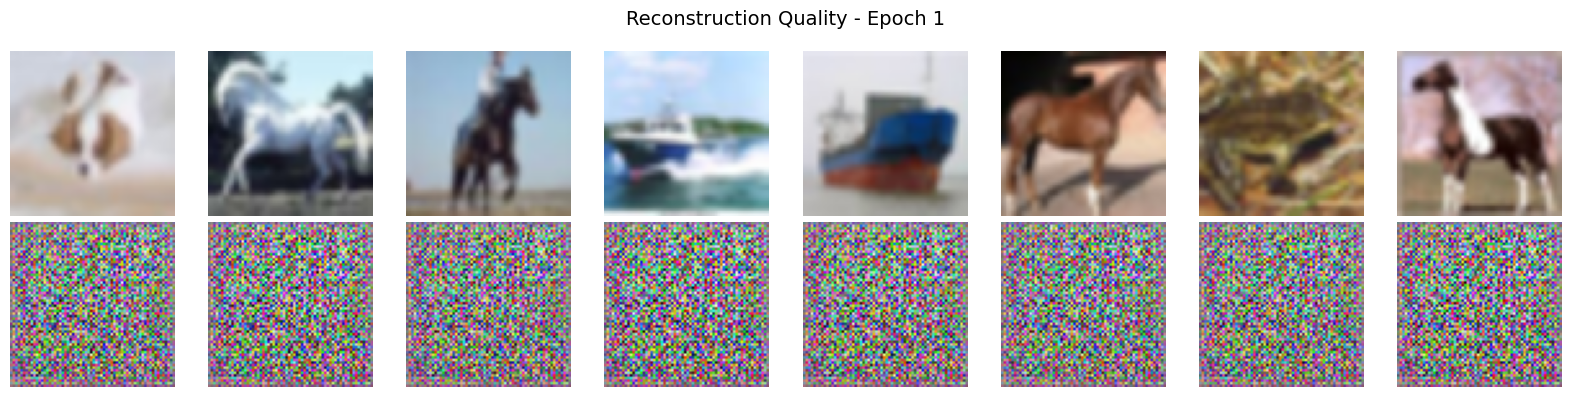

VAEGAN.Trainer | INFO | Epoch 2 Batch 0: G_loss=0.5552 C_loss=-0.2829 Recon=0.5504 GP=0.0030
VAEGAN.Trainer | INFO | Epoch 2 Batch 100: G_loss=0.5786 C_loss=-0.3032 Recon=0.5751 GP=0.0009
VAEGAN.Trainer | INFO | Epoch 2 Batch 200: G_loss=0.5452 C_loss=-0.3652 Recon=0.5506 GP=0.0035
VAEGAN.Trainer | INFO | Epoch 2 Batch 300: G_loss=0.5085 C_loss=-0.3122 Recon=0.5414 GP=0.0015
VAEGAN.Trainer | INFO | Epoch 2 Batch 400: G_loss=0.5076 C_loss=-0.1546 Recon=0.5478 GP=0.0018
VAEGAN.Trainer | INFO | Epoch 2 complete: G_loss=0.5291 C_loss=-0.2650 Recon=0.5483 KL=2.2392 Adv=-2.4316 GP=0.0027


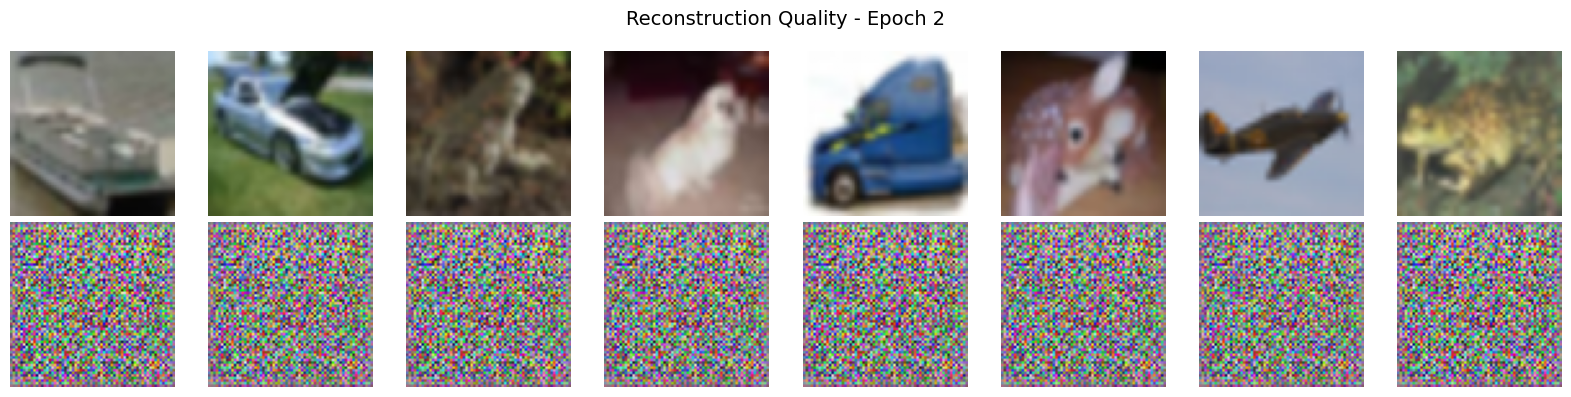

VAEGAN.Trainer | INFO | Epoch 3 Batch 0: G_loss=0.4981 C_loss=-0.3599 Recon=0.5396 GP=0.0022
VAEGAN.Trainer | INFO | Epoch 3 Batch 100: G_loss=0.4738 C_loss=-0.4411 Recon=0.5413 GP=0.0009
VAEGAN.Trainer | INFO | Epoch 3 Batch 200: G_loss=0.4472 C_loss=-0.1143 Recon=0.5435 GP=0.0009
VAEGAN.Trainer | INFO | Epoch 3 Batch 300: G_loss=0.3943 C_loss=0.0019 Recon=0.5316 GP=0.0051
VAEGAN.Trainer | INFO | Epoch 3 Batch 400: G_loss=0.3756 C_loss=0.1845 Recon=0.5308 GP=0.0016
VAEGAN.Trainer | INFO | Epoch 3 complete: G_loss=0.4209 C_loss=-0.0389 Recon=0.5342 KL=2.4303 Adv=-3.5633 GP=0.0025


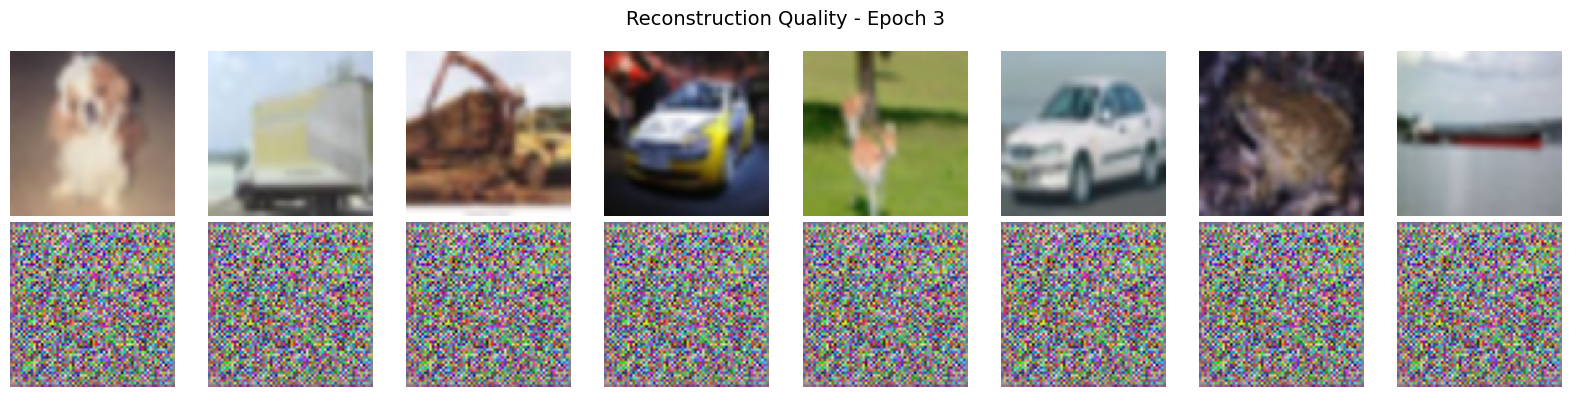

VAEGAN.Trainer | INFO | Epoch 4 Batch 0: G_loss=0.3415 C_loss=0.4377 Recon=0.5244 GP=0.0049
VAEGAN.Trainer | INFO | Epoch 4 Batch 100: G_loss=0.3624 C_loss=-0.1827 Recon=0.5116 GP=0.0017
VAEGAN.Trainer | INFO | Epoch 4 Batch 200: G_loss=0.3926 C_loss=-0.4879 Recon=0.5210 GP=0.0011
VAEGAN.Trainer | INFO | Epoch 4 Batch 300: G_loss=0.4045 C_loss=-0.8983 Recon=0.5302 GP=0.0014
VAEGAN.Trainer | INFO | Epoch 4 Batch 400: G_loss=0.4271 C_loss=-1.1379 Recon=0.5326 GP=0.0027
VAEGAN.Trainer | INFO | Epoch 4 complete: G_loss=0.3915 C_loss=-0.6901 Recon=0.5229 KL=2.5068 Adv=-3.8211 GP=0.0017


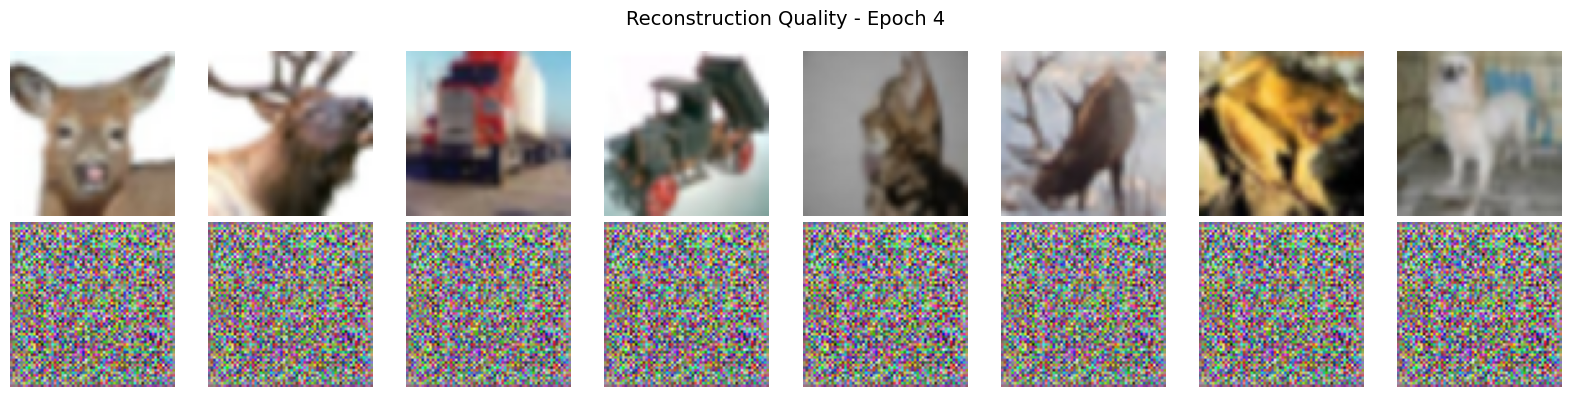

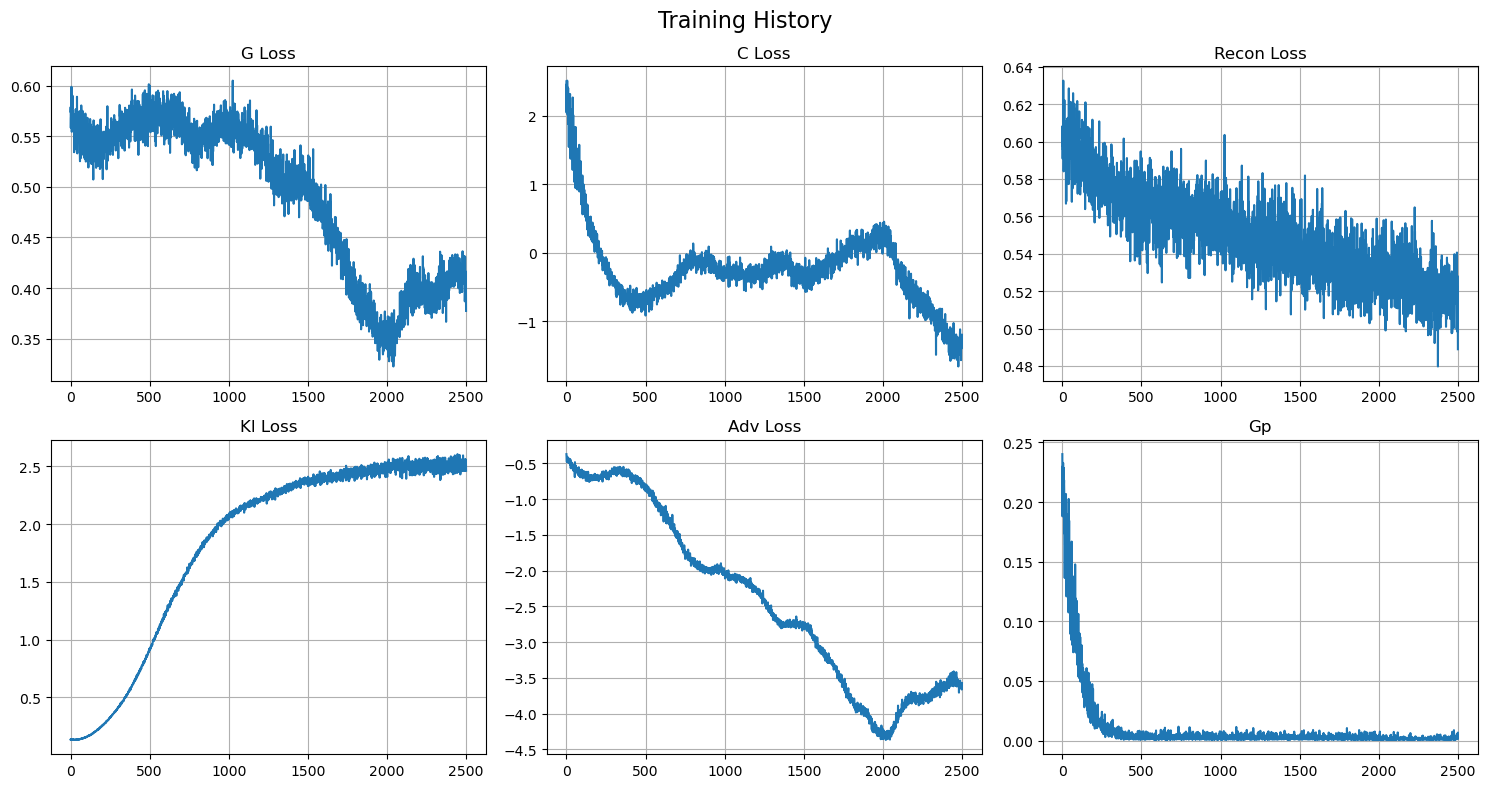

In [8]:
if __name__ == "__main__":
    # Setup
    logger.info("Starting VAEGAN training")
    logger.info("=" * 50)
    
    # Create dataloader
    data_loader = DataLoaderModule(batch_size=100)
    
    # Load MNIST dataset  
    dataloader, channels, img_size = data_loader.load_mnist()
    
    # Create dynamic model with configurable latent_dim for MNIST
    latent_dim_mnist = 64  # Smaller for MNIST
    model = VAEGAN(input_channels=channels, latent_dim=latent_dim_mnist, img_size=64, lambda_gp=10)
    
    # Create trainer
    trainer = Trainer(model, device)
    
    # Train model
    logger.info("Training on MNIST")
    trainer.train(dataloader, epochs=10, lr_g=1e-3, lr_c=1e-3)
    
    # Plot results
    trainer.plot_history()
    
    logger.info("Training completed")
    
    # Train on CIFAR10 with larger latent_dim
    logger.info("Training on CIFAR10")
    dataloader_cifar, channels_cifar, _ = data_loader.load_cifar10()
    latent_dim_cifar = 128  # Larger for CIFAR10 (3 channels, more complex)
    model_cifar = VAEGAN(input_channels=channels_cifar, latent_dim=latent_dim_cifar, img_size=64, lambda_gp=10)
    trainer_cifar = Trainer(model_cifar, device)
    trainer_cifar.train(dataloader_cifar, epochs=5, lr_g=1e-6, lr_c=1e-6)
    trainer_cifar.plot_history()
